# リスクスコアモデルの開発とテスト

## 目的
- 各ドメイン別リスクスコアモデルのテスト
- 総合リスクスコアの計算
- サンプル患者でのスコア算出
- モデルの妥当性検証

## 評価ドメイン
1. 心血管系（Cardiovascular）- 重み 30%
2. 代謝系（Metabolic）- 重み 25%
3. 腎機能（Renal）- 重み 20%
4. 肝機能（Hepatic）- 重み 15%
5. 血液系（Hematologic）- 重み 10%

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import yaml

# プロジェクトルートをパスに追加
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.models.cardiovascular_risk import CardiovascularRiskModel
from src.models.metabolic_risk import MetabolicRiskModel
from src.models.renal_risk import RenalRiskModel
from src.models.hepatic_risk import HepaticRiskModel
from src.models.hematologic_risk import HematologicRiskModel
from src.models.composite_risk import CompositeRiskModel

# 日本語フォント設定
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# 図のスタイル
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. データの読み込み

In [2]:
# 前処理済みデータの読み込み
processed_data_path = project_root / "data" / "processed" / "nhanes_processed.csv"

if processed_data_path.exists():
    df = pd.read_csv(processed_data_path)
    print(f"Loaded processed data: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
else:
    print("Processed data not found. Please run 01_data_exploration.ipynb first.")

Loaded processed data: (9254, 693)
Columns: ['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC', 'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL', 'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ', 'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'INDHHIN2', 'INDFMIN2', 'INDFMPIR', 'URXVOL1', 'URDFLOW1', 'URDTIME1', 'URXVOL2', 'URDFLOW2', 'URDTIME2', 'URXVOL3', 'URDFLOW3', 'URDTIME3', 'PHQ020', 'PHACOFHR', 'PHACOFMN', 'PHQ030', 'PHAALCHR', 'PHAALCMN', 'PHQ040', 'PHAGUMHR', 'PHAGUMMN', 'PHQ050', 'PHAANTHR', 'PHAANTMN', 'PHQ060', 'PHASUPHR', 'PHASUPMN', 'PHAFSTHR', 'PHAFSTMN', 'PHDSESN', 'LBXGH', 'URXUMA', 'URXUMS', 'URDUMALC', 'URXUCR', 'URXCRS', 'URDUCRLC', 'URDACT', 'URXPREG', 'LBXHIVC

## 2. テストケース: 正常健康者

In [3]:
# 正常健康者のサンプルデータ
healthy_patient = {
    "SEQN": 99999,
    "RIAGENDR": 1,  # Male
    "RIDAGEYR": 35,
    "LBXTC": 180,  # 総コレステロール: 正常
    "LBDHDD": 55,  # HDL: 正常
    "LBDLDL": 95,  # LDL: 最適
    "LBXTR": 100,  # 中性脂肪: 正常
    "TC_HDL_ratio": 180 / 55,
    "LBXGLU": 90,  # 血糖: 正常
    "LBXGH": 5.2,  # HbA1c: 正常
    "LBXIN": 8,  # インスリン: 正常
    "HOMA_IR": (8 * 90) / 405,
    "LBXSCR": 0.9,  # クレアチニン: 正常
    "eGFR": 105,  # eGFR: 正常
    "ACR": 15,  # ACR: 正常
    "LBXSASSI": 22,  # AST: 正常
    "LBXSGTSI": 25,  # ALT: 正常
    "LBXPLTSI": 250,  # 血小板: 正常
    "FIB4": 0.8,  # FIB-4: 低リスク
    "LBXSAL": 4.2,  # アルブミン: 正常
    "LBXSTB": 0.8,  # ビリルビン: 正常
    "LBXHGB": 15.0,  # ヘモグロビン: 正常
    "LBXWBCSI": 7.0,  # 白血球: 正常
    "LBXMCVSI": 90,  # MCV: 正常
}

print("正常健康者のサンプルデータ:")
for key, value in healthy_patient.items():
    print(f"  {key}: {value}")

正常健康者のサンプルデータ:
  SEQN: 99999
  RIAGENDR: 1
  RIDAGEYR: 35
  LBXTC: 180
  LBDHDD: 55
  LBDLDL: 95
  LBXTR: 100
  TC_HDL_ratio: 3.272727272727273
  LBXGLU: 90
  LBXGH: 5.2
  LBXIN: 8
  HOMA_IR: 1.7777777777777777
  LBXSCR: 0.9
  eGFR: 105
  ACR: 15
  LBXSASSI: 22
  LBXSGTSI: 25
  LBXPLTSI: 250
  FIB4: 0.8
  LBXSAL: 4.2
  LBXSTB: 0.8
  LBXHGB: 15.0
  LBXWBCSI: 7.0
  LBXMCVSI: 90


In [4]:
# 総合リスクスコアモデルの初期化
composite_model = CompositeRiskModel()

# スコア計算
healthy_result = composite_model.calculate_composite_score(healthy_patient)

print("\n" + "=" * 60)
print("正常健康者の評価結果")
print("=" * 60)
print(f"総合スコア: {healthy_result['composite_score']:.1f}点")
print(f"リスクレベル: {healthy_result['risk_level']} ({healthy_result['risk_label']})")
print(f"\nドメイン別スコア:")
for domain, score in healthy_result["domain_scores"].items():
    print(f"  {domain}: {score:.1f}点")
print(
    f"\n修正可能因子: {', '.join(healthy_result['modifiable_factors']) if healthy_result['modifiable_factors'] else 'なし'}"
)
print(f"\n推奨事項:")
for rec in healthy_result["recommendations"]:
    print(f"  - {rec}")


正常健康者の評価結果
総合スコア: 2.4点
リスクレベル: OPTIMAL (最適)

ドメイン別スコア:
  cardiovascular: 8.0点
  metabolic: 0.0点
  renal: 0.0点
  hepatic: 0.0点
  hematologic: 0.0点

修正可能因子: なし

推奨事項:
  - 【総合評価: 最適】
  - 優良な健康状態
  - 年1回の定期健診


## 3. テストケース: 高リスク患者

In [5]:
# 高リスク患者のサンプルデータ
high_risk_patient = {
    "SEQN": 88888,
    "RIAGENDR": 2,  # Female
    "RIDAGEYR": 68,
    "LBXTC": 280,  # 総コレステロール: 高値
    "LBDHDD": 38,  # HDL: 低値
    "LBDLDL": 210,  # LDL: 最高値
    "LBXTR": 250,  # 中性脂肪: 高値
    "TC_HDL_ratio": 280 / 38,
    "LBXGLU": 140,  # 血糖: 糖尿病域
    "LBXGH": 7.2,  # HbA1c: 糖尿病域
    "LBXIN": 25,  # インスリン: 高値
    "HOMA_IR": (25 * 140) / 405,
    "LBXSCR": 1.8,  # クレアチニン: 高値
    "eGFR": 35,  # eGFR: G3b（中等度〜高度低下）
    "ACR": 120,  # ACR: 微量アルブミン尿
    "URXUMA": 120,
    "LBXSASSI": 58,  # AST: 高値
    "LBXSGTSI": 72,  # ALT: 高値
    "LBXPLTSI": 180,  # 血小板: やや低値
    "FIB4": 2.8,  # FIB-4: 中リスク
    "AST_ALT_ratio": 58 / 72,
    "LBXSAL": 3.2,  # アルブミン: 低値
    "LBXSTB": 1.5,  # ビリルビン: 高値
    "LBXHGB": 11.0,  # ヘモグロビン: 貧血
    "LBXWBCSI": 9.5,  # 白血球: やや高値
    "LBXMCVSI": 78,  # MCV: 小球性
}

print("高リスク患者のサンプルデータ:")
for key, value in high_risk_patient.items():
    print(f"  {key}: {value}")

高リスク患者のサンプルデータ:
  SEQN: 88888
  RIAGENDR: 2
  RIDAGEYR: 68
  LBXTC: 280
  LBDHDD: 38
  LBDLDL: 210
  LBXTR: 250
  TC_HDL_ratio: 7.368421052631579
  LBXGLU: 140
  LBXGH: 7.2
  LBXIN: 25
  HOMA_IR: 8.641975308641975
  LBXSCR: 1.8
  eGFR: 35
  ACR: 120
  URXUMA: 120
  LBXSASSI: 58
  LBXSGTSI: 72
  LBXPLTSI: 180
  FIB4: 2.8
  AST_ALT_ratio: 0.8055555555555556
  LBXSAL: 3.2
  LBXSTB: 1.5
  LBXHGB: 11.0
  LBXWBCSI: 9.5
  LBXMCVSI: 78


In [6]:
# スコア計算
high_risk_result = composite_model.calculate_composite_score(high_risk_patient)

print("\n" + "=" * 60)
print("高リスク患者の評価結果")
print("=" * 60)
print(f"総合スコア: {high_risk_result['composite_score']:.1f}点")
print(
    f"リスクレベル: {high_risk_result['risk_level']} ({high_risk_result['risk_label']})"
)
print(f"\nドメイン別スコア:")
for domain, score in high_risk_result["domain_scores"].items():
    print(f"  {domain}: {score:.1f}点")

print(f"\n警告: {len(high_risk_result['alerts'])}件")
for i, alert in enumerate(high_risk_result["alerts"], 1):
    print(f"\n警告 {i}: {alert['domain']} ({alert['severity']})")
    print(f"  スコア: {alert['score']:.1f}点")
    print(f"  異常マーカー:")
    for marker in alert["abnormal_markers"]:
        print(f"    - {marker}")
    print(f"  推奨事項:")
    for rec in alert["recommendations"][:3]:  # 最初の3つ
        print(f"    - {rec}")

print(f"\n修正可能因子:")
for factor in high_risk_result["modifiable_factors"]:
    print(f"  - {factor}")


高リスク患者の評価結果
総合スコア: 100.0点
リスクレベル: CRITICAL (要精査)

ドメイン別スコア:
  cardiovascular: 100.0点
  metabolic: 100.0点
  renal: 66.0点
  hepatic: 59.4点
  hematologic: 20.0点

警告: 3件

警告 1: 心血管系 (CRITICAL)
  スコア: 100.0点
  異常マーカー:
    - LDL: 210.0 mg/dL（最高値: ≥190）
    - HDL: 38.0 mg/dL（女性低値: <50）
    - 中性脂肪: 250.0 mg/dL（高値: 200-499）
    - TC/HDL比: 7.37（高リスク: >5.0）
  推奨事項:
    - 【緊急】循環器専門医への即時紹介を推奨
    - スタチン療法の開始を検討
    - 動脈硬化性疾患の精密検査（頸動脈エコー、心臓CT等）

警告 2: 代謝系 (CRITICAL)
  スコア: 100.0点
  異常マーカー:
    - 空腹時血糖: 140.0 mg/dL（糖尿病域: ≥126）
    - HbA1c: 7.2%（糖尿病域: ≥6.5%）
    - HOMA-IR: 8.64（インスリン抵抗性: ≥2.5）
  推奨事項:
    - 【緊急】糖尿病診断のための精密検査
    - 内分泌内科/糖尿病専門医への紹介
    - 75g経口ブドウ糖負荷試験（OGTT）の実施

警告 3: 腎機能 (HIGH)
  スコア: 66.0点
  異常マーカー:
    - eGFR: 35.0（G3b: 中等度〜高度低下）
    - ACR: 120.0 mg/g（A2: 微量アルブミン尿）
    - クレアチニン: 1.80 mg/dL（基準値超過）
  推奨事項:
    - 腎臓専門医への紹介
    - CKDステージに応じた管理
    - ACE阻害薬/ARBによる腎保護

修正可能因子:
  - LDLコレステロール（食事療法・スタチン）
  - 血糖値（食事・運動・薬物療法）
  - HbA1c（糖尿病管理）
  - 中性脂肪（食事・運動・フィブラート）
  - HDLコレステロール（運動・禁煙）
  - 肝

## 4. 全データでのスコア計算

In [7]:
# 一括スコア計算（サンプル: 最初の100名）
if "df" in locals():
    print("一括スコア計算を開始...")
    df_sample = df.head(100).copy()
    df_with_scores = composite_model.batch_calculate(df_sample)

    print(f"\n計算完了: {len(df_with_scores)}名")
    print(f"\nスコア統計:")
    print(df_with_scores["composite_score"].describe())

一括スコア計算を開始...


Calculating risk scores: 100%|██████████| 100/100 [00:00<00:00, 7090.12it/s]


計算完了: 100名

スコア統計:
count    100.000000
mean      14.506000
std       13.223982
min        0.000000
25%        4.600000
50%       11.200000
75%       19.675000
max       68.300000
Name: composite_score, dtype: float64


## 5. スコア分布の可視化

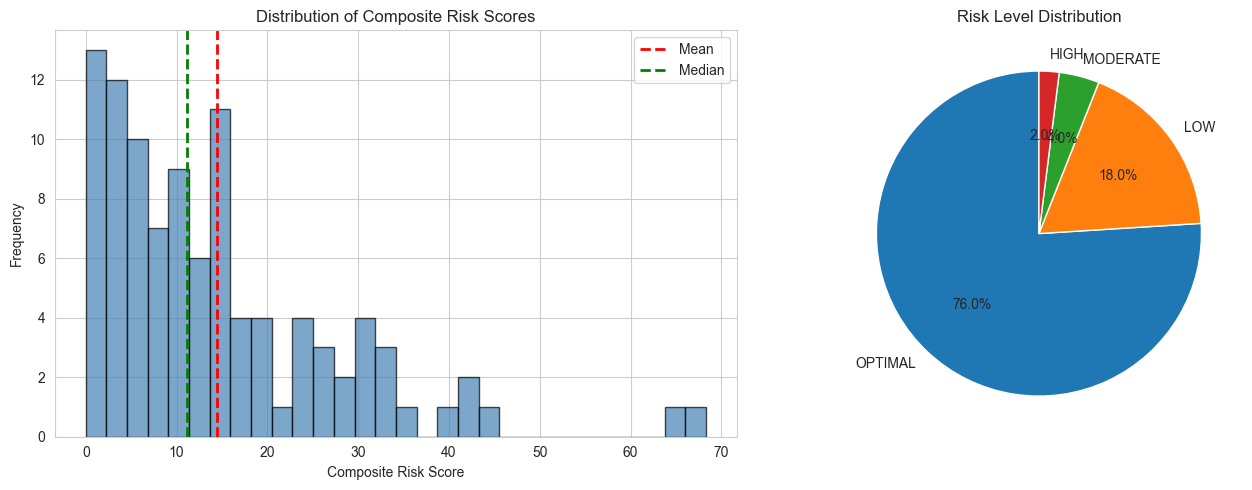

In [8]:
# 総合スコアの分布
if "df_with_scores" in locals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ヒストグラム
    axes[0].hist(
        df_with_scores["composite_score"].dropna(),
        bins=30,
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
    )
    axes[0].axvline(
        df_with_scores["composite_score"].mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label="Mean",
    )
    axes[0].axvline(
        df_with_scores["composite_score"].median(),
        color="green",
        linestyle="--",
        linewidth=2,
        label="Median",
    )
    axes[0].set_xlabel("Composite Risk Score")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Distribution of Composite Risk Scores")
    axes[0].legend()

    # リスクレベル別の割合
    risk_level_counts = df_with_scores["risk_level"].value_counts()
    axes[1].pie(
        risk_level_counts.values,
        labels=risk_level_counts.index,
        autopct="%1.1f%%",
        startangle=90,
    )
    axes[1].set_title("Risk Level Distribution")

    plt.tight_layout()
    plt.show()

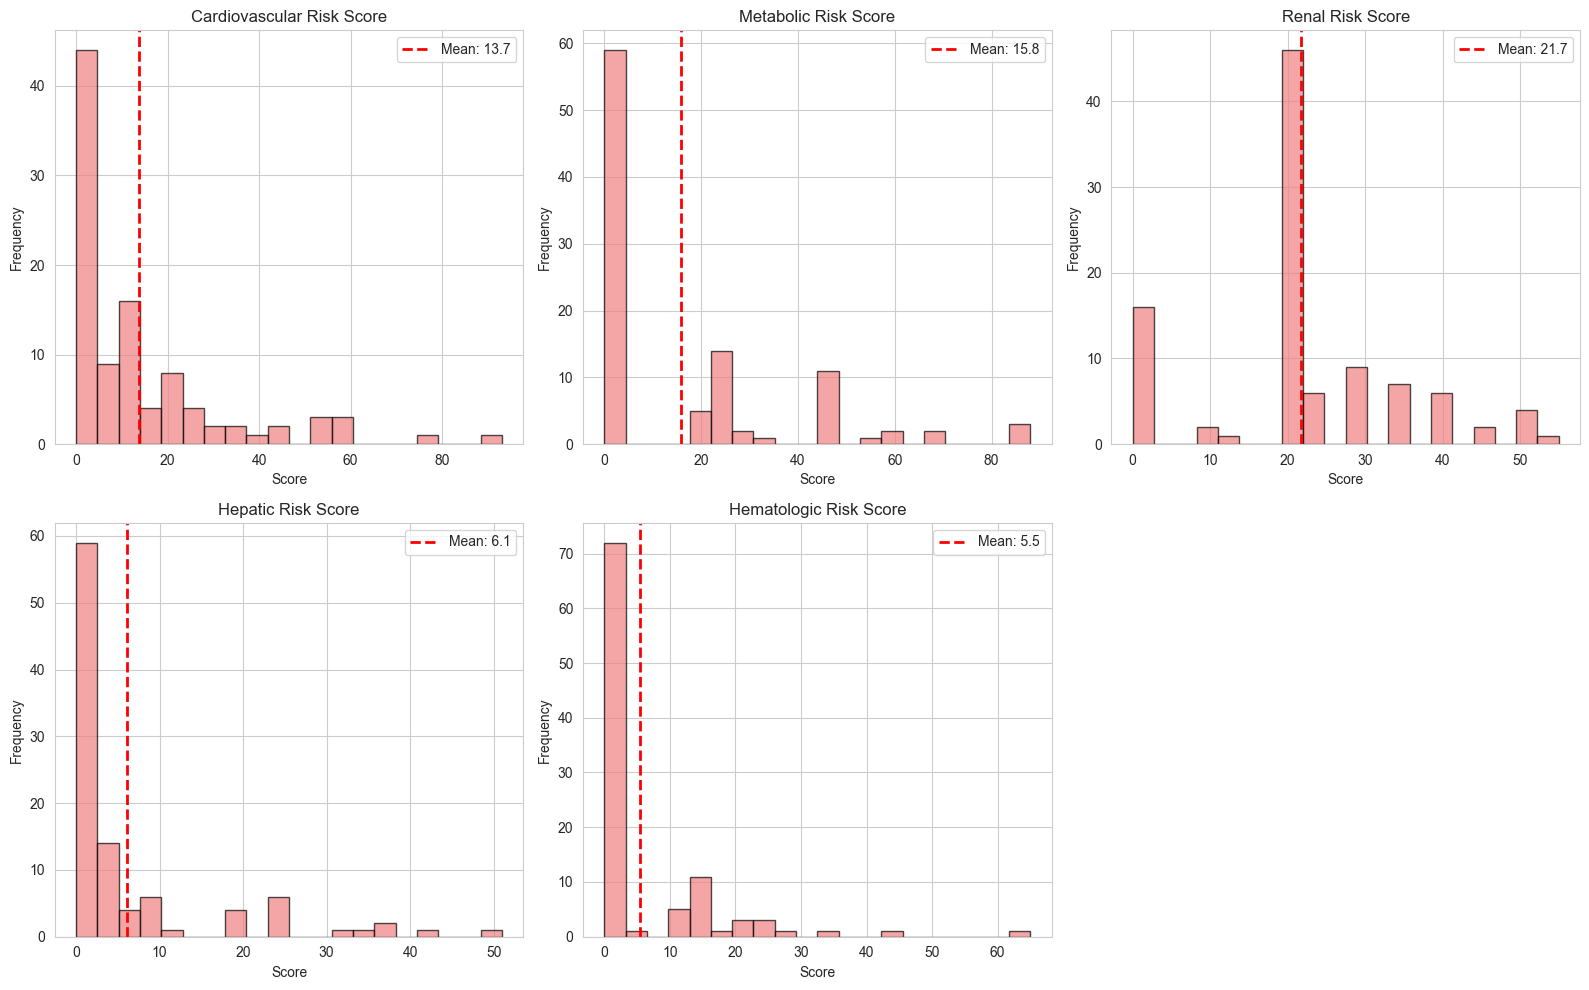

In [9]:
# ドメイン別スコアの分布
if "df_with_scores" in locals():
    domain_cols = ["cardiovascular", "metabolic", "renal", "hepatic", "hematologic"]

    # domain_scoresカラムから各ドメインスコアを抽出
    for domain in domain_cols:
        df_with_scores[f"{domain}_score"] = df_with_scores["domain_scores"].apply(
            lambda x: eval(x)[domain] if isinstance(x, str) else x.get(domain, np.nan)
        )

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.ravel()

    for i, domain in enumerate(domain_cols):
        score_col = f"{domain}_score"
        if score_col in df_with_scores.columns:
            data = df_with_scores[score_col].dropna()
            axes[i].hist(
                data, bins=20, color="lightcoral", alpha=0.7, edgecolor="black"
            )
            axes[i].axvline(
                data.mean(),
                color="red",
                linestyle="--",
                linewidth=2,
                label=f"Mean: {data.mean():.1f}",
            )
            axes[i].set_xlabel("Score")
            axes[i].set_ylabel("Frequency")
            axes[i].set_title(f"{domain.capitalize()} Risk Score")
            axes[i].legend()

    # 最後のサブプロットを非表示
    axes[5].axis("off")

    plt.tight_layout()
    plt.show()

## 6. リスクレベル別の特徴

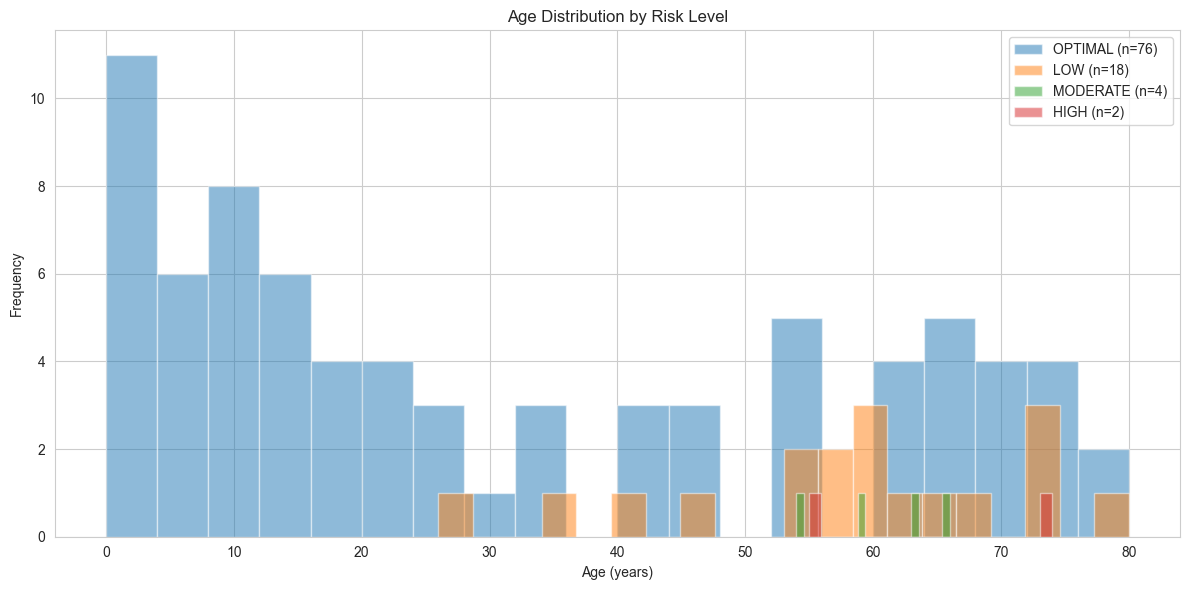

In [10]:
# リスクレベル別の年齢分布
if "df_with_scores" in locals() and "RIDAGEYR" in df_with_scores.columns:
    plt.figure(figsize=(12, 6))

    risk_levels = df_with_scores["risk_level"].unique()
    for level in risk_levels:
        data = df_with_scores[df_with_scores["risk_level"] == level][
            "RIDAGEYR"
        ].dropna()
        plt.hist(data, bins=20, alpha=0.5, label=f"{level} (n={len(data)})")

    plt.xlabel("Age (years)")
    plt.ylabel("Frequency")
    plt.title("Age Distribution by Risk Level")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 7. 高リスク患者の抽出

In [11]:
# 総合スコア80点以上の高リスク患者
if "df_with_scores" in locals():
    high_risk_patients = df_with_scores[df_with_scores["composite_score"] >= 80]

    print(
        f"高リスク患者（スコア≥80点）: {len(high_risk_patients)}名 ({len(high_risk_patients) / len(df_with_scores) * 100:.1f}%)"
    )

    if len(high_risk_patients) > 0:
        print("\n高リスク患者の特徴:")
        print(
            high_risk_patients[
                ["SEQN", "RIDAGEYR", "composite_score", "risk_level"]
            ].head(10)
        )

高リスク患者（スコア≥80点）: 0名 (0.0%)


## 8. モデル妥当性の評価

In [12]:
# 既知グループ妥当性: 糖尿病群 vs 非糖尿病群
if "df_with_scores" in locals() and "LBXGLU" in df_with_scores.columns:
    # 糖尿病の定義: 空腹時血糖≥126 または HbA1c≥6.5
    df_with_scores["diabetes"] = False

    if "LBXGLU" in df_with_scores.columns:
        df_with_scores.loc[df_with_scores["LBXGLU"] >= 126, "diabetes"] = True

    if "LBXGH" in df_with_scores.columns:
        df_with_scores.loc[df_with_scores["LBXGH"] >= 6.5, "diabetes"] = True

    # 群間比較
    diabetes_scores = df_with_scores[df_with_scores["diabetes"] == True][
        "composite_score"
    ].dropna()
    non_diabetes_scores = df_with_scores[df_with_scores["diabetes"] == False][
        "composite_score"
    ].dropna()

    print("既知グループ妥当性評価:")
    print(f"\n糖尿病群 (n={len(diabetes_scores)}):")
    print(f"  平均スコア: {diabetes_scores.mean():.1f} ± {diabetes_scores.std():.1f}")
    print(f"\n非糖尿病群 (n={len(non_diabetes_scores)}):")
    print(
        f"  平均スコア: {non_diabetes_scores.mean():.1f} ± {non_diabetes_scores.std():.1f}"
    )

    # 群間差のt検定
    from scipy import stats

    if len(diabetes_scores) > 0 and len(non_diabetes_scores) > 0:
        t_stat, p_value = stats.ttest_ind(diabetes_scores, non_diabetes_scores)
        print(f"\nt検定: t={t_stat:.2f}, p={p_value:.4f}")
        print(
            f"結論: {'糖尿病群のスコアは有意に高い' if p_value < 0.05 else 'スコア差は有意でない'}"
        )

既知グループ妥当性評価:

糖尿病群 (n=9):
  平均スコア: 39.5 ± 16.9

非糖尿病群 (n=91):
  平均スコア: 12.0 ± 9.9

t検定: t=7.36, p=0.0000
結論: 糖尿病群のスコアは有意に高い


## まとめ

このノートブックでは:
1. 各ドメイン別リスクスコアモデルのテスト
2. 総合リスクスコアの計算
3. 正常健康者と高リスク患者のテストケース評価
4. 全データでの一括スコア計算
5. スコア分布の可視化
6. リスクレベル別の特徴分析
7. 高リスク患者の抽出
8. モデルの妥当性評価（既知グループ妥当性）

を実行しました。

次のステップ:
- 04_validation_analysis.ipynb: より詳細な妥当性評価
- PDFレポート生成機能の実装